In [12]:
import os
import numpy as np
import librosa
import yaml
import matplotlib.pyplot as plt

# Updated Instrument Mapping (5 classes)
INSTRUMENT_MAPPING = {
    "Piano": 0,
    "Guitar": 1, 
    "Bass": 2,
    "Strings": 3,
    "Strings (continued)": 3,
    "Drums": 4,
}

# Paths
DATASET_PATH = "slakh2100_flac_redux/reduced_validation/"
TIMESTAMPS_FILE = "timestamps_validation.txt"
OUTPUT_DIR = "labels_validation/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [13]:
# Step 1: Build stem-to-class mapping
stem_to_class = {}
for track in sorted(os.listdir(DATASET_PATH)):
    metadata_file = os.path.join(DATASET_PATH, track, "metadata.yaml")
    if os.path.exists(metadata_file):
        with open(metadata_file, "r") as f:
            metadata = yaml.safe_load(f)
        for stem, info in metadata.get("stems", {}).items():
            inst_class = info.get("inst_class")
            if inst_class in INSTRUMENT_MAPPING:
                stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING[inst_class]

# Step 2: Process timestamps and create activity matrices
activity_matrices = {}
with open(TIMESTAMPS_FILE, "r") as f:
    for line in map(str.strip, f):
        if line.startswith("Track: "):
            track = os.path.basename(line.split("Track: ")[1].replace("\\", "/"))
            mix_file = os.path.join(DATASET_PATH, track, "mix.flac")
            if os.path.exists(mix_file):
                duration = int(np.floor(librosa.get_duration(path=mix_file)))
                activity_matrices[track] = np.zeros((5, duration), dtype=np.int8)
        elif (parts := line.split(": ")) and len(parts) == 2:
            stem_key, timestamps = f"{track}/{parts[0]}", eval(parts[1])
            if stem_key in stem_to_class:
                idx = stem_to_class[stem_key]
                for start, end in timestamps:
                    start_idx, end_idx = int(np.floor(start)), int(np.ceil(end))
                    presence = int((end - start) >= 0.1)
                    activity_matrices[track][idx, start_idx:end_idx] = presence

# Step 3: Save matrices
for track, matrix in activity_matrices.items():
    np.save(os.path.join(OUTPUT_DIR, f"{track}.npy"), matrix)

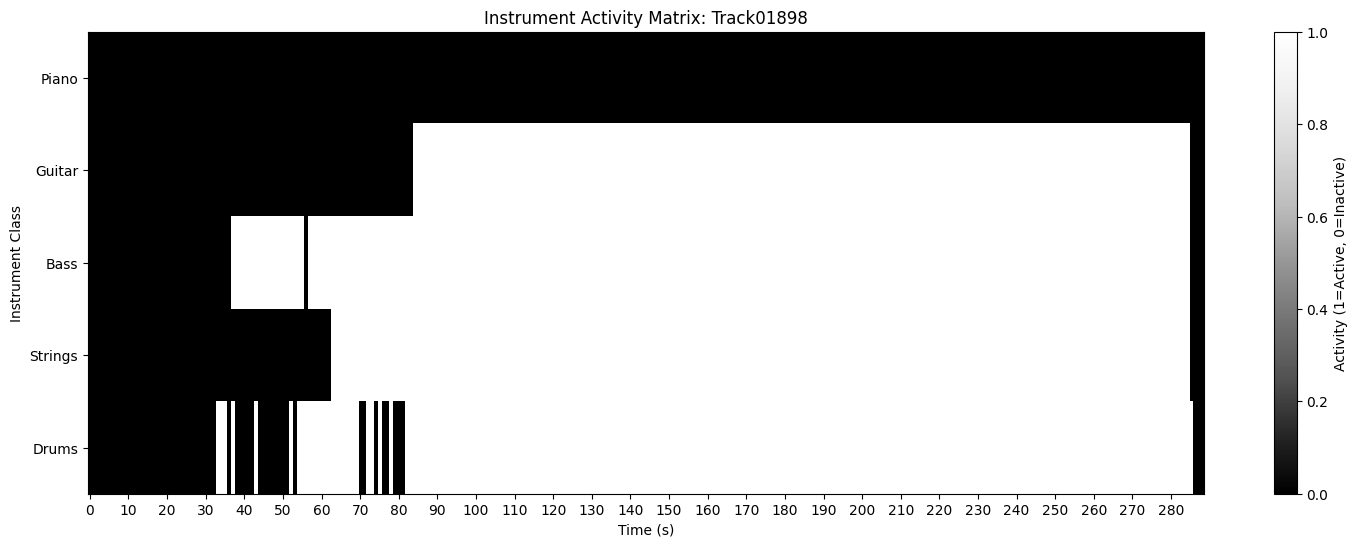

In [9]:
# --- Visualization Example ---
INSTRUMENT_LABELS = ["Piano", "Guitar", "Bass", "Strings", "Drums"]
MATRIX_PATH = "labels_test/"
example_file = sorted(os.listdir(MATRIX_PATH))[18]
matrix = np.load(os.path.join(MATRIX_PATH, example_file))

plt.figure(figsize=(18, 6))
plt.imshow(matrix, aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.yticks(range(5), INSTRUMENT_LABELS)
plt.xticks(range(0, matrix.shape[1], 10), np.arange(0, matrix.shape[1], 10))
plt.xlabel("Time (s)")
plt.ylabel("Instrument Class")
plt.title(f"Instrument Activity Matrix: {example_file[:-4]}")
plt.colorbar(label="Activity (1=Active, 0=Inactive)")
plt.show()